# Imports

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
from collections import Counter
from collections import defaultdict
import json

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/apon/anaconda3/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data  

### Tangram Tutorial Data

In [2]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

# Get training genes

In [3]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1401

# Prepare and run mapping

In [4]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="constrained",  #filter cells, not all cells will be mapped
    #mode="cells",
    density_prior='rna_count_based',
    target_count=10200,    
    lambda_d = 0.89,
    lambda_g2 = 0.99,
    num_epochs=500,
    device='cpu',
)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in constrained mode...


Score: 0.613, VG reg: 0.798, KL reg: 0.001, Count reg: 677.281, Lambda f reg: 4476.518
Score: 0.731, VG reg: 0.807, KL reg: 0.000, Count reg: 6.273, Lambda f reg: 658.490
Score: 0.733, VG reg: 0.807, KL reg: 0.000, Count reg: 0.106, Lambda f reg: 164.297
Score: 0.734, VG reg: 0.807, KL reg: 0.000, Count reg: 0.079, Lambda f reg: 81.990
Score: 0.734, VG reg: 0.807, KL reg: 0.000, Count reg: 0.042, Lambda f reg: 52.359


INFO:root:Saving results..


# Cell type distribution in a single voxel

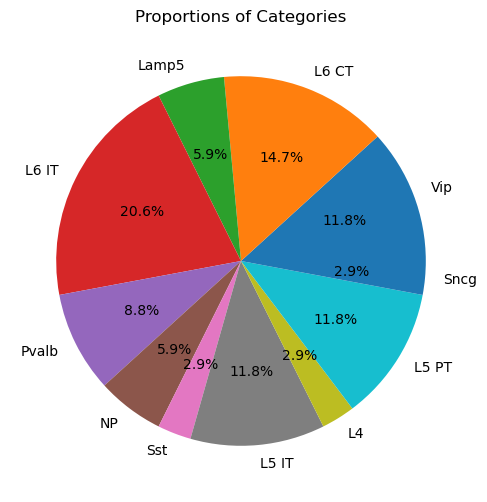

In [5]:
#SINGLE VOXEL IMPLEMENTATION
from collections import Counter

indices = np.where(ad_map.X[:, 0] > 0.9)[0] #indices of cells mapped to the voxel with high probability

cell_subclass_counts = Counter(list(ad_map.obs.cell_subclass.iloc[indices])) #count celltypes

total = sum(cell_subclass_counts.values()) # total cells

proportions = {key: value / total for key, value in cell_subclass_counts.items()} # calculate proportions

plt.figure(figsize=(6, 6))
plt.pie(proportions.values(), labels=proportions.keys(), autopct="%1.1f%%")
plt.title("Proportions of Categories")
plt.show()

# All voxel celltype distribution with threshold 90% mapping probability

In [6]:
# Get matrix dimensions
print(len(list(adata_sc.obs["cell_subclass"].unique()))) #number of celltypes
print(ad_map.n_vars) #number of voxels

23
324


In [7]:
cell_types = list(adata_sc.obs["cell_subclass"].unique()) #celltypes in sc data

num_cell_types = len(cell_types)
num_voxels = ad_map.n_vars 

ct_dist_matrix = np.zeros((num_cell_types, num_voxels)) #init np array with dim (n_ct x n_voxels)

#CELLTYPE DISTRIBUTIONS
for i in range(num_voxels):
    indices = np.where(ad_map.X[:, i] > 0.9)[0]  # Cells mapped to voxel i with high probability
    
    if len(indices) > 0:
        cell_counts = Counter(ad_map.obs.cell_subclass.iloc[indices])  #get counts for each celltype
        total = sum(cell_counts.values())  #total cells mapped with high prob in voxel i
        
        for cell_type, count in cell_counts.items():
            row_idx = cell_types.index(cell_type)  #get index for a given celltype
            ct_dist_matrix[row_idx, i] = count / total  #write value


ct_dist_matrix = np.array(ct_dist_matrix) #convert to np array
np.savetxt('tg_ct_dist.txt', ct_dist_matrix, fmt='%f') #save np array to file

#print(celltype_distribution_matrix[:, 0]) 
#loaded_file = np.loadtxt('tg_ct_dist.txt', dtype=float)

# All voxel celltype distribution without threshold

In [5]:
cell_types = list(adata_sc.obs["cell_subclass"].unique()) #celltypes in sc data
num_cell_types = len(cell_types)
num_voxels = ad_map.n_vars 

ct_dist_matrix = np.zeros((num_cell_types, num_voxels)) #init np array with dim (n_ct x n_voxels)
weighted_counts = defaultdict(float)

### SUBSET ad_map based on F_out (learned filter) ###
ad_map = ad_map[ad_map.obs["F_out"] > 0.5].copy()

#CELLTYPE DISTRIBUTIONS
for i in range(num_voxels):
    indices = np.where(ad_map.X[:, i] > 0.0)[0]  # Cells mapped to voxel i 
    
    if len(indices) > 0:
        
        for cell in indices:
            weighted_counts[ad_map.obs.cell_subclass.iloc[cell]] += ad_map.X[cell, i] #votes are weighted by map prob
        
        total = sum(weighted_counts.values()) #total to calculate distributions
        
        for cell_type, count in weighted_counts.items():
            row_idx = cell_types.index(cell_type)  #get index for a given celltype
            ct_dist_matrix[row_idx, i] = count / total  #write value


ct_dist_matrix = np.array(ct_dist_matrix) #convert to np array
np.savetxt('tg_ct_dist_no_thresh.txt', ct_dist_matrix, fmt='%f') #save np array to file

#print(ct_dist_matrix[:, 0])
#loaded_file = np.loadtxt('tg_ct_dist.txt', dtype=float)

In [11]:
print(adata_sc.n_obs - ad_map.n_obs, "cells trimmed by filter, out of", adata_sc.n_obs)

11505 cells trimmed by filter, out of 21697


# Overrepresented ct in data??

In [9]:
ct_counts = Counter(adata_sc.obs.cell_subclass)
total = sum(ct_counts.values())

for key in ct_counts:
    ct_counts[key] = round(ct_counts[key] / total, 3)

print(ct_counts)
print(total)

Counter({'L5 IT': 0.136, 'Vip': 0.122, 'Sst': 0.117, 'L6 IT': 0.1, 'Pvalb': 0.095, 'Lamp5': 0.085, 'L4': 0.062, 'L6 CT': 0.056, 'L2/3 IT': 0.054, 'L5 PT': 0.041, 'NP': 0.034, 'Astro': 0.025, 'L6b': 0.021, 'Sncg': 0.011, 'Oligo': 0.009, 'Endo': 0.007, 'Macrophage': 0.006, 'VLMC': 0.006, 'SMC': 0.005, 'Serpinf1': 0.004, 'Meis2': 0.003, 'Peri': 0.001, 'CR': 0.001})
21697


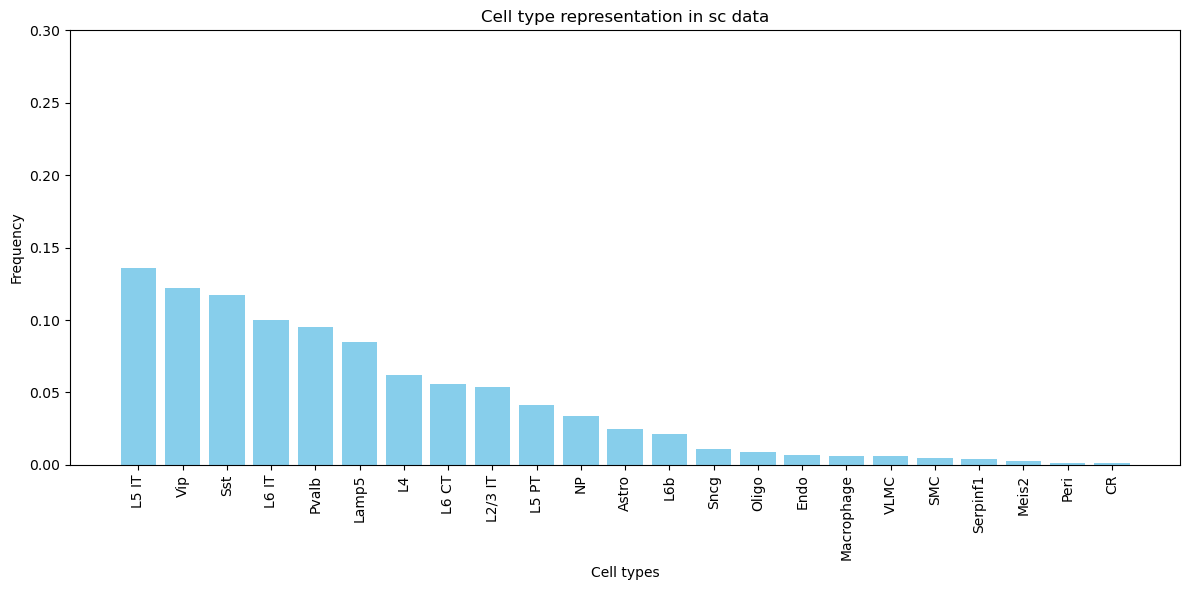

In [10]:
ct_counts = dict(sorted(ct_counts.items()))

# Extract keys and values
categories = list(ct_counts.keys())
values = list(ct_counts.values())

# Plot
plt.figure(figsize=(12, 6))  # Adjust width if needed
plt.bar(categories, values, color='skyblue')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Cell types')
plt.ylabel('Frequency')
plt.title('Cell type representation in sc data')
plt.tight_layout()
plt.ylim([0.0, 0.3])
plt.show()

In [13]:
with open('ct_abundance_sc.json', 'w') as f:
    json.dump(ct_counts, f)


In [17]:
!less ct_abundance_sc_RAW.json

{"Astro": 545, "CR": 17, "Endo": 155, "L2/3 IT": 1172, "L4": 1340, "L5 IT": 2952, "L5 PT": 895, "L6 CT": 1220, "L6 IT": 2166, "L6b": 457, "Lamp5": 1837, "Macrophage": 131, "Meis2": 55, "NP": 733, "Oligo": 185, "Peri": 28, "Pvalb": 2065, "SMC": 106, "Serpinf1": 84, "Sncg": 244, "Sst": 2534, "VLMC": 131, "Vip": 2645}
ct_abundance_sc_RAW.json (END){"Astro": 545, "CR": 17, "Endo": 155, "L2/3 IT": 1172, "L4": 1340, "L5 IT": 2952, "L5 PT": 895, "L6 CT": 1220, "L6 IT": 2166, "L6b": 457, "Lamp5": 1837, "Macrophage": 131, "Meis2": 55, "NP": 733, "Oligo": 185, "Peri": 28, "Pvalb": 2065, "SMC": 106, "Serpinf1": 84, "Sncg": 244, "Sst": 2534, "VLMC": 131, "Vip": 2645}
~
~
~
~
~
~
~
~
~
~
~
~
~
~
~
~
~
~
~
(END)

# Raw counts

In [15]:
ct_counts = Counter(adata_sc.obs.cell_subclass)

ct_counts = dict(sorted(ct_counts.items()))

with open('ct_abundance_sc_RAW.json', 'w') as f:
    json.dump(ct_counts, f)
